In [1]:
import warnings
warnings.simplefilter('ignore')

#Fetch MNIST dataset
from sklearn.datasets import fetch_mldata

mnist=fetch_mldata('MNIST original')
mnist

/home/aquib/anaconda3/envs/tf-2-gpu/lib/python2.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)
/home/aquib/anaconda3/envs/tf-2-gpu/lib/python2.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)


{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([0., 0., 0., ..., 9., 9., 9.])}

In [2]:
X,y=mnist["data"], mnist["target"]
X.shape, y.shape

((70000, 784), (70000,))

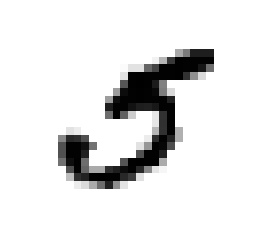

5.0

In [3]:
#display feature vector by reshaping to 28x28
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit=X[36000]
some_digit_image=some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()
y[36000]

In [4]:
#create train and testset
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000],y[60000:]

In [5]:
#shuffle data
import numpy as np

shuffle_index=np.random.permutation(60000)
X_train, y_train=X_train[shuffle_index], y_train[shuffle_index]

In [6]:
#target vectors for "5-detector"
y_train_5 = (y_train==5) # true for all 5s, false for all other digits
y_test_5=(y_test==5)

In [7]:
#create SGDClassifier and train on whole training set
from sklearn.linear_model import SGDClassifier

sgd_clf=SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

#use it to detect images of 5
sgd_clf.predict([some_digit])

array([False])

In [8]:
#implementing cross validation
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds=StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf=clone(sgd_clf)
    X_train_folds=X_train[train_index]
    y_train_folds=(y_train_5[train_index])
    X_test_fold=X_train[test_index]
    y_test_fold=(y_train_5[test_index])
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred=clone_clf.predict(X_test_fold)
    n_correct=sum(y_pred==y_test_fold)
    print(float(n_correct)/len(y_pred))

0.9534
0.9479
0.96505


In [9]:
# use cross_val_score()
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9534 , 0.9479 , 0.96505])

In [10]:
# dumb classifier that classifies every single image in "not-5" class
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X),1),dtype=bool)

# model's accuracy
never_5_clf=Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90755, 0.91195, 0.90945])

Confusion Matrix

In [11]:
# to compute confusion matrix, first make predictions on train set using cross_val_predict()
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [12]:
#get confusion matrix using confusion_matrix() passing the target class y_train_5
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[54142,   437],
       [ 2236,  3185]])

A perfect classifier would have only true positives and true negatives, so its confusion matrix would have non-zero values on its main diagonal

In [13]:
y_train_perfect_predictions=y_train_5 # perfect predictions
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

Precision - Accuracy of positive predictions
precision = TP/(TP+FP)

Precision used along with recall, also called sensitivity or True Positive rate which is the ratio of postive instances that are correctly detected by classifier
- recall = TP/(TP+FN)

In [14]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.879348426283821

In [15]:
recall_score(y_train_5, y_train_pred)

0.5875299760191847

When 5-detector claims an image represets a 5, it is correct only 71% and it only detects 81% of 5s.

In [16]:
#combine precision and recall in F1-score which is 
#the harmonic mean of both of them
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7044122525710494

Increasing precision reduces recall, and vice versa, and this is called precision/recall tradeoff

In [17]:
# Instead of calling classifiers predict() method, we use decision_functions().
# It returns a score for each instance and then make predictions based
# on those scores using any threshold we want
y_scores=sgd_clf.decision_function([some_digit])
y_scores

array([-58767.32881667])

In [18]:
threshold=0
y_some_digit_pred = (y_scores>threshold)
y_some_digit_pred

array([False])

In [19]:
# with threshold as 0, previous code returns smae result as predict()
threshold=200000
y_some_digit_pred=(y_scores>threshold)
y_some_digit_pred

array([False])

This confirms raising threshold decreases recall. 
To select threshold, first get scores of all  instances in training set using cross_val_predict() but specify to return decision scores instead of predictions.

In [20]:
y_scores=cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, 
method="decision_function")

With these scores, we can compute precision and recall for all possible thresholds using precision_recall_curve() function

In [21]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

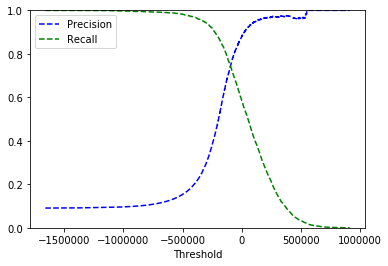

In [22]:
# plot precision and recall as function of threshold value using Matplotlib
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0,1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [23]:
# to make predictions with 90% precision, threshold is 150,000 and we can just run
y_train_pred_90 = (y_scores > 150000)

# to check this predictions precision and recall
precision_score(y_train_5, y_train_pred_90), recall_score(y_train_5, y_train_pred_90)

(0.9569838056680162, 0.348828629404169)

ROC Curve -
Another common tool used with binary classifiers and plots TPR against FPR (also called plot of sensitivity (recall) versus (1-specificity))

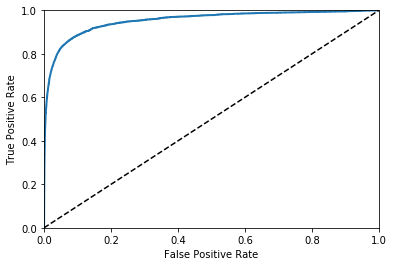

In [24]:
# to plot roc curve, first compute tpr and fpr for various thresholds
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel("True Positive Rate")
    
plot_roc_curve(fpr, tpr)
plt.show()

Again there is a tradeoff: higher recall (TPR), more FPR the classifier produces. Dotted line represents ROC curve of purely random classifier; a good classifier stays as far away from that line as possible (toward top-left corner).

One way to compare classifiers is to measure Area under curve. A perfect classifier will have ROC AUC equal to 1 and a purely random classifier will have a ROC AUC equal to 0.5

In [25]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9532982183060659

Train a RandomForestClassifier and compare its ROC curve and ROC AUC score to SGDClassifier

In [26]:
from sklearn.ensemble import RandomForestClassifier
forest_clf=RandomForestClassifier(random_state=42)
y_probas_forest=cross_val_predict(forest_clf, X_train, y_train_5, 
                                 cv=3, method="predict_proba")

In [27]:
"""To plot ROC curve we need scores not probabilities and probabilities and 
we can use positive class probability as score"""
y_scores_forest = y_probas_forest[:,1] #score=proba of positive class
fpr_forest, tpr_forest, thresholds_forest=roc_curve(y_train_5, y_scores_forest)

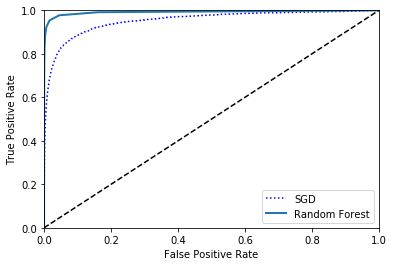

In [28]:
#plot roc curve
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

RandomForestClassifier's ROC curve is better than SGDClassifier, as it comes much closer to top-left corner and as a result ROC AUC score is also better

In [29]:
roc_auc_score(y_train_5, y_scores_forest)

0.992036091771463

# Multiclass Classification

In [30]:
# Sk-Learn detects when we try binary classification for multiclass classification
# and it automatically runs OvA
sgd_clf.fit(X_train,y_train) #y_train, not y_train_5
sgd_clf.predict([some_digit])

array([5.])

In [31]:
#decision_function() returns 10 scores one per class
some_digit_scores=sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-155163.4450557 , -411229.70040428, -245359.44759683,
        -237323.02307152, -408149.75973003,  -58767.32881667,
        -670454.94683598, -157471.39634974, -725423.36963769,
        -563456.47258044]])

In [32]:
#highest score is the corresponding to class 5
np.argmax(some_digit_scores)

5

In [33]:
sgd_clf.classes_

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [34]:
# this code creates a multiclass classifier using OvO strategy based on SGDClassifier
from sklearn.multiclass import OneVsOneClassifier
ovo_clf=OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5.])

In [35]:
len(ovo_clf.estimators_)

45

In [36]:
# Training RandomForestClassifier
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5.])

In [37]:
# call predict_proba to get list of probabilities
forest_clf.predict_proba([some_digit])

array([[0. , 0. , 0. , 0.2, 0. , 0.8, 0. , 0. , 0. , 0. ]])

In [38]:
# evaluate SGDClassifier accuracy using cross_val_score()
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87127574, 0.87164358, 0.87493124])

In [39]:
# bettter results can be obtained by scaling the inputs
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.91046791, 0.90674534, 0.91018653])

# Error Analysis

In [40]:
# analyse the types of errors model makes
# make predicions using cross_val_predic() and call confusion_matrix()
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx=confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5734,    3,   25,    8,   10,   47,   46,    9,   37,    4],
       [   2, 6496,   41,   23,    6,   41,    8,   13,   99,   13],
       [  54,   39, 5338,   97,   75,   30,   88,   60,  160,   17],
       [  50,   44,  137, 5315,    2,  255,   35,   58,  133,  102],
       [  22,   25,   47,    8, 5351,    9,   57,   28,   81,  214],
       [  68,   43,   32,  180,   63, 4612,  120,   27,  179,   97],
       [  33,   24,   53,    2,   39,   91, 5623,    7,   46,    0],
       [  24,   26,   64,   33,   47,   10,    7, 5802,   15,  237],
       [  51,  170,   76,  155,   17,  159,   59,   27, 4991,  146],
       [  47,   30,   31,   90,  147,   36,    2,  207,   73, 5286]])

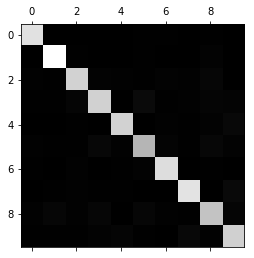

In [41]:
# it is more convenient to look at image representation
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

Confusion matrix looks fairly good because most images are on main diagonal, meaning they were classified correctly. 

# Multilabel Classification

In [42]:
# simple example of multilabel classification
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >=7)
y_train_odd=(y_train%2==1)
y_multilabel=np.c_[y_train_large, y_train_odd]

knn_clf=KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [43]:
# above code creates two target labels
# first indicates whether or not digit is large (7, 8 or 9)
# second indicates whether or not it is odd
# make prediction and we see it has two labels
knn_clf.predict([some_digit])

array([[False,  True]])

The classifier gets it right, as 5 is not large (False) and odd (True)

y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)
f1_score(y-train, y_train_knn_pred, average="macro")

# Multioutput Classification

It is simply a generalization of multilabel classification where each label can be multiclass. For example we build a system that takes an input a noisy digit image and output a clean digit image. The classifier's output is multilabel (one label per pixel) and each label can have multiple values.

In [44]:
noise=np.random.randint(0,100,(len(X_train),784))
X_train_mod=X_train+noise
noise=np.random.randint(0,100,(len(X_test),784))
X_test_mod=X_test+noise
y_train_mod=X_train
y_test_mod=X_test

In [52]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off")

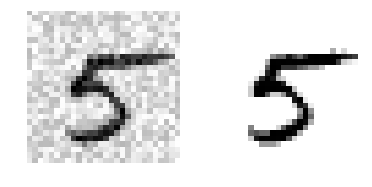

In [54]:
some_index=5500
plt.subplot(121);plot_digit(X_test_mod[some_index])
plt.subplot(122);plot_digit(y_test_mod[some_index])
plt.show()

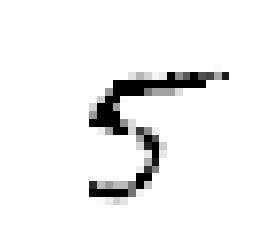

In [55]:
# train the classifier and make it a clean image
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit=knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)